# Importing and calling data files


In [78]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd
import os
#import reionizer
import glob
import astropy
import astropy.cosmology
from astropy.cosmology import Planck15 as P15
from astropy import units as u
from astropy import constants as const
from scipy import interpolate
from scipy.optimize import minimize

plt.style.use(['default','seaborn-colorblind','seaborn-ticks'])
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'



In [79]:
def insensitive_glob(pattern):
    """
    Case insensitive find file names
    """
    def either(c):
        return '[%s%s]'%(c.lower(),c.upper()) if c.isalpha() else c
    return glob.glob(''.join(map(either,pattern)))

#Call UV LF data files
LFz_data_dir = os.environ['LYA_DATA_DIR']+'data/models/' #calls directory
LFz_dir = LFz_data_dir+'MTT15_UVLF/LF_pred/' #inside models folder call MTT15_UVLF/LF_pred/ folder
LFz_files = sorted(insensitive_glob(LFz_dir+'LF_pred_z*.txt')) 
#calls each file in modelled data * will be replaced with corresponding zval

#Calling EW files and their Muv values
pW_data_dir = os.environ['LYA_DATA_DIR']+'data/models/' 
pW_dir = pW_data_dir+'M18_z=7.0_lnpWobs_Muv/' #inside models folder call M18_z=7.0_lnpWobs_Muv folder
pW_files = sorted(insensitive_glob(pW_dir+'ln_pWobs_*.txt')) #calls each file in modelled data * will be replaced with corresponding xHI

#Calling Konno data file
K_data_dir = os.environ['LYA_DATA_DIR']+'data/models/' 
K_dir = pW_data_dir+'Lya_LF_Konno/' 
K_files = sorted(insensitive_glob(K_dir+'Lya_LF_Konno_z*.txt')) 



# Methodology
## Defining function to call files


In [80]:
#Function used to load files
def load_uvf_pandas(ufl_filename): 
    """
    Load table into pandas df
    """
    uvf_tab_df = pd.read_csv(ufl_filename, skiprows=1, delim_whitespace=True)
    
    # Shuffle the column names to remove the '#' from the first column
    uvf_tab_df.columns = np.roll(uvf_tab_df.columns, -1)

    # Cut off the last (empty) column
    uvf_tab_df = uvf_tab_df.iloc[:, :-1]

    return uvf_tab_df



#Call UV LF files by calling file name at specific z value 
LFz_tab = np.array([float(f.split('LF_pred_z')[-1].split('.txt')[0]) for f in LFz_files]) 


#Call xHI, EW files
xHI_tab = np.array([float(f.split('xHI=')[-1].split('.txt')[0]) for f in pW_files]) 

#Call Konno z value files
Konno_tab = np.array([float(f.split('z')[-1].split('.txt')[0]) for f in K_files])

#Call EW file with xHI = 0.01 
#global pW_tab
pW_tab = load_uvf_pandas(pW_files[0]) 

#Get Muv values from EW file as an array to use
Muv_EW = np.array([float(Muv_val) for Muv_val in pW_tab.columns[1:]])



## Defining constants and evaluating equations for given z value. Interpolating data between UV LF and Lya EW, Lya LF and L Grid

In [81]:
#Constants and constraints
xHI_array = np.array([0.29]) #chosen xHI value
# zval_test = np.array([5.9]) #chosen redshifts
Konno_zval = np.array([5.7,6.6])
Muv_array = np.array([-18.0,-22.0,-16.0]) #chosen Muv to test lum_lya vs Muv similar to EW vs Muv
beta = -2.0 #usually -2 for high z galaxies as per spectrum as power law
pc_10 = 10 * u.pc #1 pc to Mpc
wl_lya = 1216 * u.Angstrom #angstrom
wl_uv = 1500 * u.Angstrom #angstrom
f0 = 3.631e-20 * (u.erg/u.s) * (u.cm**(-2)) * (u.Hz**(-1)) #flux_0 in erg s^-1 cm^-2 Hz^-1
c = const.c #speed of light
lum_grid = np.logspace(42.5,44) #shape = (50,)
log10_lg = np.log10(lum_grid) #log10 luminosity grid in order to plot it on log10 scale similar to past works

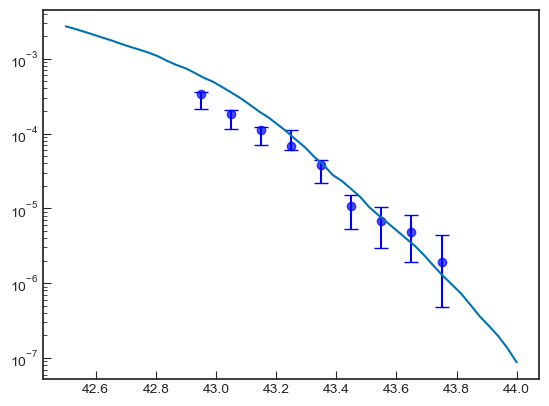

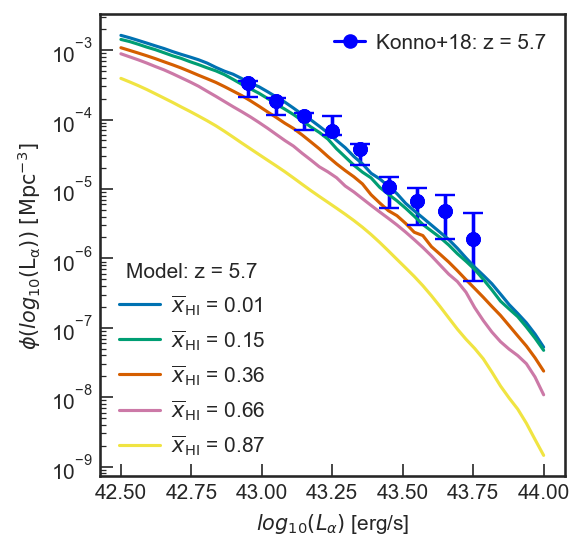

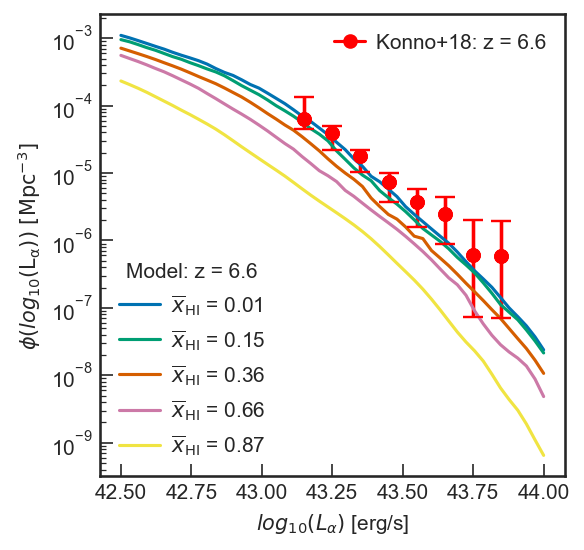

In [189]:
#Defining lya LF function and all necessary eqs needed 

def make_lya_LF(zval_test, xHI_test, F=1., plot=False):
    
    #Calling UV, EW, Konno files to obtain z and xHI values
    LFz_file = sorted(insensitive_glob(LFz_dir+ f'LF_pred_z{zval_test}.txt'))[0] 
    pW_file = sorted(insensitive_glob(pW_dir+f'ln_pWobs_*{xHI_test}.txt'))[0]
    K_file = sorted(insensitive_glob(K_dir+f'Lya_LF_Konno_z*{zval_test}.txt'))[0] #Will require data from Unix account

    
    #Load in z value file
    LF_tab = load_uvf_pandas(LFz_file) 
    
    #Load in xHI value file
    pW_tab = load_uvf_pandas(pW_file)
    
    
    #Get Muv values from file as an array to use
    Muv_EW = np.array([float(Muv_val) for Muv_val in pW_tab.columns[1:]])
    
    
    #Interpolating UV LF Muv and ndens values into a 1d array
    LF_interp = interpolate.interp1d(LF_tab['Muv'],LF_tab['ndens']) #old values
    new_ndens = LF_interp(Muv_EW)

    
    #Defines distance modulus
    d_l = P15.luminosity_distance(zval_test) 
    
    
    #Define apparent magnitude equation
    def muv(Muv_EW,d_l,zval_test): 
        p1 = Muv_EW
        p2 = 5*(np.log10((d_l/pc_10).to(u.pc/u.pc))) #convert d_l/pc_10 to pc units and then dimensionless
        ans = p1 + p2
        return ans
    muv = muv(Muv_EW,d_l,zval_test)


    #Flux density of UV continuum at Lya wavelength from Muv for given zvals
    fd_uv = f0 * (10**(-0.4*muv)) *(c/(wl_lya**2)) *((wl_lya/wl_uv)**(beta+2.0))
    fd_units = fd_uv.to(u.erg/u.s* (u.cm**(-2))/u.Angstrom) ##use this to show units

    
    #Jacobian - partial EW / partial Lya Luminosity for given zvals 
    jacobian = 1/((4*np.pi*d_l**2.)*fd_units)

    # Flux_Lya
    EW_200 = pW_tab['W'][9002]
    f_lya = np.outer(pW_tab['W'],fd_units) * u.Angstrom
    
    f_test = f_lya[9002]
    
    #Lya luminosity 
    lum_lya = (f_lya * (4*np.pi*d_l**2.)).to(u.erg/u.s)
    
    
    #Drops first column of EW values
    new_pW_tab = np.exp(pW_tab.drop('W',axis=1))
    #new_pW_tab = pW_tab.drop('W',axis=1) this was original code, was changed to exponential form

    
    #EW values for each Muv in EW file
    pEW_vals = np.array(new_pW_tab) 


    # P(Lya|Muv)
    pLya = jacobian * pEW_vals

    
    #Normalizes pLya to correctly plot lum_lya vs pLya
    A1 = pLya[0] #first term of p(L) integral, where these lum = 0 (the height in y)(-inf to 0)
    integral = np.trapz(pLya[1:].T,lum_lya.value[1:].T) #second term for lum>0 (L>0 to inf) transposed to correct matrix 
    sum_int = A1 + integral #This is whole integral of p(L)dL
    norm_pLya = pLya / sum_int #new normalized pLya, divide original pLya values by integral to normalize

    new_A1 = norm_pLya[0]
    integral2 = np.trapz(norm_pLya[1:].T,lum_lya.value[1:].T)
    new_sum = new_A1 + integral2 #verifies that new normalized integral adds up to 1 
    assert(new_sum.value.all() == 1.)

    
    #Define an empty matrix in order to fill later with luminosity grid values and Muv values
    new_pLya = np.zeros((len(lum_grid), len(Muv_EW))) 

    for mm,Muv in enumerate (Muv_EW):
        #Interpolating pLya and ndens values into a 1d array
        LF_interp1 = interpolate.interp1d(lum_lya[:,mm],norm_pLya[:,mm],fill_value=0., bounds_error=False)
        new_pLya[:,mm] = LF_interp1(lum_grid) #column values of pLya
    
        
    #Product of UVLF ndens values * pLya in new luminosity grid
    product_LF = new_ndens * new_pLya 


    #Integral of this product = Lya LF (missing fudge factor corrections)
    lya_LF =np.trapz(product_LF, x = Muv_EW) 


    #Log10 of Lya LF is lya_LF value * Jacobian - partial L / partial log10(L)
    log10_LF = lya_LF*np.log(10)*lum_grid
     
    #Plotting Information
    if plot == True:
        #Plot Konno info 
        konno_data_plt(zval_test, plot = True)
#         #Jacobian vs Muv plot info
#         plot_jvsMuv(jacobian, Muv_EW, zval_test)
#         #Plot Lum vs PLum info
#         LvsPLya(Muv_array, zval_test, lum_lya, norm_pLya, new_pLya)
    
    

    
    return F*log10_LF
log10_LF_calibrate = make_lya_LF(zval_test = 5.7,xHI_test = 0.01, F = 1., plot=True)
plt.semilogy(log10_lg, log10_LF_calibrate,label = '$\overline{x}_\mathrm{HI}$ = 0.01')

plt.figure(figsize=(4.,4.), dpi=150)
log10_LF6 = make_lya_LF(zval_test = 5.7,xHI_test = 0.01,F=0.602, plot=True)
plt.semilogy(log10_lg, log10_LF6,label = '$\overline{x}_\mathrm{HI}$ = 0.01')

log10_LF7 = make_lya_LF(zval_test = 5.7,xHI_test = 0.15,F=0.602,plot=True)
plt.semilogy(log10_lg, log10_LF7, label = '$\overline{x}_\mathrm{HI}$ = 0.15')

log10_LF8 = make_lya_LF(zval_test = 5.7,xHI_test = 0.36, F=0.602, plot=True)
plt.semilogy(log10_lg, log10_LF8,label = '$\overline{x}_\mathrm{HI}$ = 0.36')

log10_LF9 = make_lya_LF(zval_test = 5.7,xHI_test = 0.66, plot=True)
plt.semilogy(log10_lg, log10_LF9,label = '$\overline{x}_\mathrm{HI}$ = 0.66')

log10_LF10 = make_lya_LF(zval_test = 5.7,xHI_test = 0.87, plot=True)
plt.semilogy(log10_lg, log10_LF10,label = '$\overline{x}_\mathrm{HI}$ = 0.87')

plt.xlabel(r'$log_{10}({L_\alpha})$ [erg/s]')
plt.ylabel(r'$\phi(log_{10}(\mathrm{L_\alpha}))\ \mathrm{[Mpc^{-3}]}$')
leg_zval2 = plt.legend(title = 'Model: z = 5.7',frameon=False, handletextpad=0.5, loc="lower left")
plt.gca().add_artist(leg_zval2)
line2 = mlines.Line2D([], [], color='blue', marker='o', label=r'Konno+18: z = 5.7')
plt.legend(handles=[line2], loc='upper right', frameon=False, handletextpad=0.5, handlelength=1.5)
plt.savefig('KonnovsLF5.7.pdf', bbox_inches='tight')
plt.show()



plt.figure(figsize=(4.,4.), dpi=150)
log10_LF1 = make_lya_LF(zval_test = 6.6,xHI_test = 0.01, F=0.602, plot=True)
plt.semilogy(log10_lg, log10_LF1,label = '$\overline{x}_\mathrm{HI}$ = 0.01')

log10_LF2 = make_lya_LF(zval_test = 6.6,xHI_test = 0.15,F=0.602,plot=True)
plt.semilogy(log10_lg, log10_LF2, label = '$\overline{x}_\mathrm{HI}$ = 0.15')

log10_LF3 = make_lya_LF(zval_test = 6.6,xHI_test = 0.36,F=0.602, plot=True)
plt.semilogy(log10_lg, log10_LF3,label = '$\overline{x}_\mathrm{HI}$ = 0.36')

log10_LF4 = make_lya_LF(zval_test = 6.6,xHI_test = 0.66, plot=True)
plt.semilogy(log10_lg, log10_LF4,label = '$\overline{x}_\mathrm{HI}$ = 0.66')

log10_LF5 = make_lya_LF(zval_test = 6.6,xHI_test = 0.87, plot=True)
plt.semilogy(log10_lg, log10_LF5,label = '$\overline{x}_\mathrm{HI}$ = 0.87')

plt.xlabel(r'$log_{10}({L_\alpha})$ [erg/s]')
plt.ylabel(r'$\phi(log_{10}(\mathrm{L_\alpha}))\  \mathrm{[Mpc^{-3}]}$')
leg_zval = plt.legend(title = 'Model: z = 6.6',frameon=False, handletextpad=0.5)
plt.gca().add_artist(leg_zval)
line1 = mlines.Line2D([], [], color='red', marker='o', label=r'Konno+18: z = 6.6')
plt.legend(handles=[line1], loc='upper right', frameon=False, handletextpad=0.5, handlelength=1.5)
plt.savefig('KonnovsLF6.6.pdf', bbox_inches='tight')
plt.show()


[0.60243553]


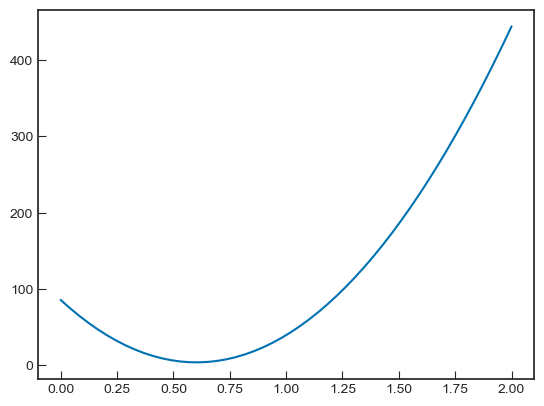

In [148]:
def line_model(F, Ko_L):
    """
    Evaluate a straight line model at the input x values.
    
    Parameters
    ----------
    F : list, array
        This should be a length-2 array or list containing the 
        parameter values (a, b) for the (slope, intercept).
    new_phiLF : numeric, list, array
        The coordinate values.
        
    Returns
    -------
    Ko_ndens : array
        The computed y values at each input x.
    """
    #Interpolating Konno and lum grid 
    LF_interp2 = interpolate.interp1d(log10_lg, log10_LF_calibrate)
    new_phi_Li = LF_interp2(Ko_L)
    
    return F*new_phi_Li

F = np.linspace(0,2)

def weighted_squared_deviation(F):
    """
    Compute the weighted squared deviation between the data 
    (x, y, y_err) and the model points computed with the input 
    parameters (pars).
    """
    Ko_L, Ko_ndens, yerror_mean = konno_data_plt(zval_test=5.7, plot = False)
    chi = (Ko_ndens - line_model(F[:,None], Ko_L)) / yerror_mean
    return np.sum(chi**2, axis=1)
plt.plot(F, weighted_squared_deviation(F))


x0 = 0.6 # starting guess for the optimizer 
result_sq = minimize(weighted_squared_deviation, x0=x0,method='BFGS')
best_pars_sq = result_sq.x
print(best_pars_sq)

In [ ]:
# # #z=6.6 plot
# plt.figure(figsize=(4.,4.), dpi=150)
# # log10_LF1 = make_lya_LF(zval_test = 6.6,xHI_test = 0.01, plot=True)
# # plt.semilogy(log10_lg, log10_LF1,label = 'z = 6.6 @ xHI = 0.01')

# log10_LF2 = make_lya_LF(zval_test = 6.6,xHI_test = 0.15,plot=True)
# plt.semilogy(log10_lg, log10_LF2, label = 'xHI = 0.15')

# log10_LF3 = make_lya_LF(zval_test = 6.6,xHI_test = 0.36, plot=True)
# plt.semilogy(log10_lg, log10_LF3,label = 'xHI = 0.36')

# log10_LF4 = make_lya_LF(zval_test = 6.6,xHI_test = 0.66, plot=True)
# plt.semilogy(log10_lg, log10_LF4,label = 'xHI = 0.66')

# log10_LF5 = make_lya_LF(zval_test = 6.6,xHI_test = 0.87, plot=True)
# plt.semilogy(log10_lg, log10_LF5,label = 'xHI = 0.87')

# plt.xlabel(r'$log_{10}({L(\mathrm{L_\alpha})})$, [$erg/s$]')
# plt.ylabel(r'$\phi(log_{10}(\mathrm{L_\alpha}))\ [Mpc^-3]$')
# leg_zval = plt.legend(frameon=False, handletextpad=0.5)
# plt.gca().add_artist(leg_zval)
# line1 = mlines.Line2D([], [], color='red', marker='o', label=r'Konno+18: z = 6.6')
# plt.legend(handles=[line1], loc='lower left', frameon=False, handletextpad=0.5, handlelength=1.5)
# plt.savefig('KonnovsLF6.6.pdf', bbox_inches='tight')
# plt.show()

# plt.figure(figsize=(4.,4.), dpi=150)
# log10_LF4 = make_lya_LF(zval_test = 5.7,xHI_test = 0.07, plot=True)
# plt.semilogy(log10_lg, log10_LF4,label = 'z = 5.7 @ xHI = 0.07')
# log10_LF5 = make_lya_LF(zval_test = 5.7,xHI_test = 0.15,plot=True)
# plt.semilogy(log10_lg, log10_LF5, label = 'z = 5.7 @ xHI = 0.15')
# log10_LF6 = make_lya_LF(zval_test = 5.7,xHI_test = 0.29, plot=True)
# plt.semilogy(log10_lg, log10_LF6,label = 'z = 5.7 @ xHI = 0.29')
# plt.xlabel(r'$log_{10}({L(\mathrm{L_\alpha})})$, [$erg/s$]')
# plt.ylabel(r'$\phi(log_{10}(\mathrm{L_\alpha}))\ [Mpc^-3]$')
# plt.legend(frameon=False, handletextpad=0.5)
# plt.savefig('KonnovsLF5.7.pdf', bbox_inches='tight')
# plt.show()

# Test Code

In [39]:
#Plot UV LF values vs interpolated Muv that is the same as EW 
def plot_UV_LF(Muv_EW,new_ndens):
    plt.semilogy(LF_tab['Muv'],LF_tab['ndens'],label = 'z = %.1f'%zval_test) #UV LF values (181 Muv vals)
    plt.plot(Muv_EW,new_ndens,'o')#EW Values along UV LF plot (61 Muv vals)
    #Muv values for EW are restricted in range, we'll have to extend range, use same EW PD > -23 and < -17 
    plt.legend()
    plt.xlabel('$M_\mathrm{UV}$')
    plt.ylabel(r'$\phi(M_\mathrm{UV})\ Mpc^-3$')
    plt.show()
    return



In [16]:
def plot_jvsMuv(jacobian, Muv_EW, zval_test):
#Shows a positive linear relationship b/t Muv and jacobian, (fd_uv vs Muv shows neg. LR)
#As Muv becomes fainter, value for jacobian increases, they're inversely proportional?

    plt.semilogx(jacobian, Muv_EW, label = 'z = %.1f'%zval_test)     
    plt.legend()
    plt.xlabel(r'$\partial EW/\partial L_\alpha$, [$\mathrm{\AA} cm^2 s/erg Mpc^2$]')
    plt.ylabel('$M_\mathrm{UV}$')
    plt.title('Jacobian vs $M_\mathrm{UV}$ for a Given Redshift ')
    return


In [158]:
def konno_data_plt(zval_test, plot = False):
    K_file = sorted(insensitive_glob(K_dir+f'Lya_LF_Konno_z*{zval_test}.txt'))[0]
    Ko_tab = load_uvf_pandas(K_file)
    
   
    yerr_l = 10**(Ko_tab['log(ndens)']) - 10**(Ko_tab['ndens_l2']) 
    yerr_u = 10**(Ko_tab['ndens_u2']) - 10**(Ko_tab['log(ndens)'])
    yerror = np.array([yerr_l,yerr_u])
    
    Ko_ndens = np.array(10**(Ko_tab['log(ndens)']))
    Ko_L = np.array(Ko_tab['log(L)'])
    yerror_mean = np.mean(yerror,axis=0)
    

    if plot==True:
        if zval_test == 5.7:
            my_color = 'blue'
            label2 = 'Konno+18: z = %.1f'%zval_test
        elif zval_test == 6.6:
            my_color = 'red'
            label2 = 'Konno+18: z = %.1f'%zval_test



        plt.semilogy(Ko_tab['log(L)'], 10**(Ko_tab['log(ndens)']),color=my_color, alpha=0.7, marker='o', lw=0)
        plt.errorbar(Ko_tab['log(L)'], 10**(Ko_tab['log(ndens)']),yerr=yerror, fmt = ' ',capsize=5, color=my_color)
    return Ko_L, Ko_ndens, yerror_mean


In [20]:
def log10_LF_plot(zval_test,xHI_test):
    for i in range(0,5):
        plt.figure(figsize=(4.,4.), dpi=150)
        log10_LF[i] = make_lya_LF(zval_test,xHI_test, plot=True)
        plt.semilogy(log10_lg, log10_LF[i],label = f'z = *{zval_test} @ xHI = {xHI_test}')
    plt.xlabel(r'$log_{10}({L(\mathrm{L_\alpha})})$, [$erg/s$]')
    plt.ylabel(r'$\phi(log_{10}(\mathrm{L_\alpha}))\ [Mpc^-3]$')
    plt.legend(frameon=False, handletextpad=0.5)
    return
    

In [70]:
def LvsPLya(Muv_array, zval_test, lum_lya, norm_pLya, new_pLya):
    for mm,Muv in enumerate (Muv_array):
            if mm == 0: #first item in Muv_array, i.e. -18.0
                ls = 'solid'
                label = 'z = %.1f'%zval_test
            elif mm == 1: #second item in Muv_array, i.e. -22.0 (will not show on xHI legend)
                ls = 'dashed'
                label = None
            elif mm == 2: # Third item in Muv_array, i.e. -16.0
                ls = 'dashdot'
                plt.loglog(lum_lya[:,mm], norm_pLya[:,mm], ls=ls, color = my_color, label = label) #[:,mm] gets corresponding column than row [mm]
                plt.plot(lum_grid, new_pLya[:,mm], ls=ls, color = 'blue')

    leg_zval = plt.legend(frameon=False, handletextpad=0.5)
    plt.gca().add_artist(leg_zval)
    #This is the legend for Muv values, -18.0 is solid, -22.0 is dashed, -16.0 is dash-dot
    line2 = mlines.Line2D([], [], color='k', label=r'$M_\mathrm{UV} = %.1f$' % Muv_array[0])
    line3 = mlines.Line2D([], [], color='k', ls='dashed', label=r'$M_\mathrm{UV} = %.1f$' % Muv_array[1])
    line1 = mlines.Line2D([], [], color='k', ls='dashdot', label=r'$M_\mathrm{UV} = %.1f$' % Muv_array[2])
    plt.legend(handles=[line1, line2, line3], loc='lower left', frameon=False, handletextpad=0.5, handlelength=1.5)

    plt.ylim(1e-50,1e-44)
    plt.xlabel(r'${\mathrm{L_\alpha}}$, [$erg/s$]')
    plt.ylabel(r'${ P (L_\alpha \;|\; M_\mathrm{UV})}$')
    return

In [59]:
for zz,zval2 in enumerate (LFz_tab): 
    if zval2 in zval_test:
                   
        if zval2 == 5.9:
            my_color = 'gray'               
        else:
            my_color = 'purple'  

#Within if statement, this is for identifying xHI legend (values and corresponding colors)
        for mm,Muv in enumerate (Muv_array):
            if mm == 0: #first item in Muv_array, i.e. -18.0
                ls = 'solid'
                label = 'z = %.1f'%zval2
            elif mm == 1: #second item in Muv_array, i.e. -22.0 (will not show on xHI legend)
                ls = 'dashed'
                label = None
            elif mm == 2: # Third item in Muv_array, i.e. -16.0
                ls = 'dashdot'
                plt.semilogy(log10_lg, log10_LF, color = 'black', label='z = 5.9')
#         for yy,zval3 in enumerate(Konno_tab):
#             if zval3 in Konno_zval:
#                 Ko_tab = load_uvf_pandas(K_files[yy])
#                 yerr_l = 10**(Ko_tab['log(ndens)']) - 10**(Ko_tab['ndens_l2']) 
#                 yerr_u = 10**(Ko_tab['ndens_u2']) - 10**(Ko_tab['log(ndens)'])
#                 yerror = [yerr_l,yerr_u]

#                 if zval3 == 5.7:
#                     my_color = 'bo'
#                     label2 = 'z = %.1f'%zval3
#                 elif zval3 == 6.6:
#                     my_color = 'ro'
#                     label2 = 'z = %.1f'%zval3


            #These are all different plots that use the same info in order to plot, that can be commented out 

                    plt.loglog(lum_lya[:,mm], norm_pLya[:,mm], ls=ls, color = my_color, label = label) #[:,mm] gets corresponding column than row [mm]
                    plt.plot(lum_grid, new_pLya[:,mm], ls=ls, color = 'blue')


#                 plt.semilogy(log10_lg, log10_LF, color = 'black', label='z = 5.9')

#                 plt.plot(Ko_tab['log(L)'], 10**(Ko_tab['log(ndens)']),my_color, label=label2, alpha=0.5)
#                 plt.errorbar(Ko_tab['log(L)'], 10**(Ko_tab['log(ndens)']),yerr=yerror, fmt = ' ',capsize=5)

        
        #plt.semilogy(lum_lya[:,mm],pW_tab['W'], ls=ls, color = my_color, label = label) #[:,mm] gets corresponding column than row [mm]

leg_zval = plt.legend(frameon=False, handletextpad=0.5)
plt.gca().add_artist(leg_zval)

#Lum grid VS LF Plot 
plt.xlabel(r'$log_{10}({L(\mathrm{L_\alpha})})$, [$erg/s$]')
plt.ylabel(r'$\phi(log_{10}(\mathrm{L_\alpha}))\ [Mpc^-3]$')


#L vs pLya Plot
#This is the legend for Muv values, -18.0 is solid, -22.0 is dashed, -16.0 is dash-dot
line2 = mlines.Line2D([], [], color='k', label=r'$M_\mathrm{UV} = %.1f$' % Muv_array[0])
line3 = mlines.Line2D([], [], color='k', ls='dashed', label=r'$M_\mathrm{UV} = %.1f$' % Muv_array[1])
line1 = mlines.Line2D([], [], color='k', ls='dashdot', label=r'$M_\mathrm{UV} = %.1f$' % Muv_array[2])
plt.legend(handles=[line1, line2, line3], loc='lower left', frameon=False, handletextpad=0.5, handlelength=1.5)

plt.ylim(1e-50,1e-44)
plt.xlabel(r'${\mathrm{L_\alpha}}$, [$erg/s$]')
plt.ylabel(r'${ P (L_\alpha \;|\; M_\mathrm{UV})}$')
# #ylabel [$\mathrm{\AA} cm^2 s/erg Mpc^2$]
# plt.tight_layout()
# #Save the figure
# plt.savefig('LvsPLya.pdf', dpi=300, bbox_inches='tight')

# plt.show()


# Plot UV LF values vs interpolated Muv that is the same as EW 
#         plt.semilogy(LF_tab['Muv'],LF_tab['ndens'],label = 'z = %.1f'%zval2) #UV LF values (181 Muv vals)
#         plt.plot(Muv_EW,new_ndens,'o')#EW Values along UV LF plot (61 Muv vals)
#         #Muv values for EW are restricted in range, we'll have to extend range, use same EW PD > -23 and < -17 
#         plt.legend()
#         plt.xlabel('$M_\mathrm{UV}$')
#         plt.ylabel(r'$\phi(M_\mathrm{UV})\ Mpc^-3$')
#         plt.show()



#Plot jacobian vs Muv
        # Shows a positive linear relationship b/t Muv and jacobian, (fd_uv vs Muv shows neg. LR)
        # As Muv becomes fainter, value for jacobian increases, they're inversely proportional?
#         plt.semilogx(jacobian, Muv_EW, label = 'z = %.1f'%zval2)
        
# plt.legend()
# plt.xlabel(r'$\partial EW/\partial L_\alpha$, [$\mathrm{\AA} cm^2 s/erg Mpc^2$]')
# plt.ylabel('$M_\mathrm{UV}$')
# plt.title('Jacobian vs $M_\mathrm{UV}$ for a Given Redshift ')
        
# #Save the figure(s), rename figure title
# plt.savefig('LyaLFplot.pdf', dpi=300, bbox_inches='tight')

# plt.show()
        

        

NameError: name 'log10_LF' is not defined